# SIMULATION #

### Packages

In [1]:
import os

import numpy as np
import pandas as pd

import datetime
import math
import time
import import_ipynb
import prepare_data_SIDES as sides_pdr
#import find_difficulty_with_irt as find_difficulty

from sklearn.metrics import accuracy_score

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
from sklearn.utils import resample

import matplotlib.pyplot as plt
import copy
import random
import math

import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px


importing Jupyter notebook from prepare_data_SIDES.ipynb


## Functions

In [2]:
def uncertainty_k(n, a, b,update_for):
    """
    - Most Elo extensions use an "uncertainty function" instead of a constant K.
    - The uncertainty function is used to adjust the size of the update based on the amount of data available.
    - For new players (students), the skill estimate is highly uncertain, and the update should be larger. As more data becomes available, the size of the update should get smaller.
    - Papoušek et al. (2014) and Nižnan et al. (2015) set `a` to 1 and `b` to 0.05 in their uncertainty function.
    - Abdi et al. (2019) set `a` to 1.8 and `b` to 0.05 in their experiments on public datasets.
    - In educational applications, there is often an asymmetry in the number of available answers for items and students. Each item is answered by many students, whereas for students, the number of answers is typically smaller by orders of magnitude.
    - Pelanek et al. (2016) suggest using different uncertainty functions for items and students may be useful in such cases.
    - Experience suggests that in the case of student modeling, it may be sufficient to model uncertainty in a simpler, pragmatic way (Nižnan et al., 2015).
    """
    u = a / (1 + (b*n))
    #u = 0.1
    # set a lower bound on uncertainty if update is for a student and if u<0.03
    if update_for == 'student' and np.any(u < 0.03):
        u = 0.03
    return u

In [3]:
def probability_guessing(n_opt,answer_type):
    """
    Calculates the probability of a student answering a multiple-choice question
    (with n_opt options and n_correct_opt correct options) correctly by chance, assuming
    that the student can choose any number of options from 1 (see if you want 0 check option into probability?)
    to n_opt.
    Note that: If the question has only 1 correct answer then the probability is 1/n_opt. 
    (assuming that students know that they have to choose only 1 option) !!! Check if there is such info for multianswer
    """
    n_combinations = sum([math.comb(n_opt, k) for k in range(1,n_opt + 1)])
    p = 1 / (n_opt if answer_type == 'QUA' else n_combinations)
    
    return p

In [4]:

def target_difficulty(student_rating, condition, range_of_success_rate,n_options_min=2, n_options_max=10):
    
    # open a combination_df 
    combination_df = pd.DataFrame(columns=['target_question_rating_min','target_question_rating_max','exact_target_question_rating','n_options','answer_type'])
    condition_min= condition - range_of_success_rate
    condition_max= condition + range_of_success_rate
    # for each n_options from 1 to 10 calculate the probability of guessing the correct answer
    # and the probability of answering correctly based on knowledge
    for answer_type in ['QUA','QMA']:
        for n_options in range(n_options_min, n_options_max+1):
            guess_prob = probability_guessing(n_options,answer_type)
            knowledge_prob = 1 - guess_prob  # probability of answering correctly based on knowledge
            if (condition_min - guess_prob != 0) and (condition_max - guess_prob != 0):
                if knowledge_prob / (condition_min - guess_prob) > 1 and knowledge_prob / (condition_max - guess_prob) > 1:
                    target_question_rating_min = student_rating + np.log((knowledge_prob / (condition_min - guess_prob)) - 1)
                    target_question_rating_max = student_rating + np.log((knowledge_prob / (condition_max - guess_prob)) - 1)
                    exact_target_question_rating = student_rating + np.log((knowledge_prob / (condition - guess_prob)) - 1)
                    # target_question_rating= np.log((np.exp(student_rating)*(knowledge_prob-condition+guess_prob))/(condition-guess_prob))

                else:
                    target_question_rating_min = np.nan
                    target_question_rating_max = np.nan
                    exact_target_question_rating = np.nan
            else:
                target_question_rating_min = np.nan
                target_question_rating_max = np.nan
                exact_target_question_rating = np.nan
            
            # fill the combination dataframe with target_question_rating, n_options, answer_type
            # and condition
            combination_df = pd.concat([combination_df, pd.DataFrame({'target_question_rating_min': [target_question_rating_min], 'exact_target_question_rating': [exact_target_question_rating], 'target_question_rating_max': [target_question_rating_max], 'n_options': [n_options], 'answer_type': [answer_type]})], ignore_index=True)

    return combination_df

### select question

In [5]:
# def select_question(target_question_rating_combinations ,this_question_list,student_rating, condition, range_of_success_rate):
    
#     # select a random question from the question_list that delta is close to question_rating by a range of range_of_targeted_difficulty
#     # if there is no question in the question_list that delta is close to question_rating by a range of range_of_targeted_difficulty, then select a random question from the question_list that delta is close to question_rating by a range of range_of_targeted_difficulty*2

#     # for each row in target_question_rating_combinations select all the rows in this_question_list where delta is in between min_question_rating and max_question_rating and n_options is equal to n_options and answer_type is equal to answer_type 
#     for index, row in target_question_rating_combinations.iterrows():
#         min_question_rating = row['target_question_rating_min']
#         max_question_rating = row['target_question_rating_max']
#         n_options = row['n_options']
#         answer_type = row['answer_type']
        
#         # Calculate the minimum and maximum values for the interval
#         interval_min = min(min_question_rating, max_question_rating)
#         interval_max = max(min_question_rating, max_question_rating)
    
#         # select all the rows in this_question_list where delta is in between min_question_rating and max_question_rating and n_options is equal to n_options and answer_type is equal to answer_type
#         question_list_in_range = this_question_list[(this_question_list['delta'] >= interval_min) & (this_question_list['delta'] <= interval_max) & (this_question_list['n_options'] == n_options) & (this_question_list['answer_type'] == answer_type)]
#         # concat the question_list_in_range to the question_list_in_range_df
#         if index == 0:
#             question_list_in_range_df = question_list_in_range
#         else:
#             question_list_in_range_df = pd.concat([question_list_in_range_df, question_list_in_range], ignore_index=True)
            
#     # second run of the for loop if the question_list_in_range_df is empty
#     if len(question_list_in_range_df) == 0:
#         # then rerun the target_difficulty function with a range_of_success_rate+0.02
#         target_question_rating_combinations=target_difficulty(student_rating, condition, range_of_success_rate+0.02, n_options_min=2, n_options_max=10)
        
#         # rerun the for loop
#         for index, row in target_question_rating_combinations.iterrows():
#             min_question_rating = row['target_question_rating_min']
#             max_question_rating = row['target_question_rating_max']
#             n_options = row['n_options']
#             answer_type = row['answer_type']
#             # select all the rows in this_question_list where delta is in between min_question_rating and max_question_rating and n_options is equal to n_options and answer_type is equal to answer_type
#             question_list_in_range = this_question_list[(this_question_list['delta'] >= min_question_rating) & (this_question_list['delta'] <= max_question_rating) & (this_question_list['n_options'] == n_options) & (this_question_list['answer_type'] == answer_type)]
#             # concat the question_list_in_range to the question_list_in_range_df
#             if index == 0:
#                 question_list_in_range_df = question_list_in_range
#             else:
#                 question_list_in_range_df = pd.concat([question_list_in_range_df, question_list_in_range], ignore_index=True)
        

#     # select a random question from the question_list_in_range
#     if len(question_list_in_range_df) > 0:
#         delta_is_in_range=1
#         question_id = random.choice(question_list_in_range_df['item_id'])
#         # find the delta of the selected question
#         question_delta = question_list_in_range_df[question_list_in_range_df['item_id'] == question_id]['delta'].values[0]
#         # find the n_options of the selected question
#         question_n_options = question_list_in_range_df[question_list_in_range_df['item_id'] == question_id]['n_options'].values[0]
#         # find the answer_type of the selected question
#         question_answer_type = question_list_in_range_df[question_list_in_range_df['item_id'] == question_id]['answer_type'].values[0]
#         # find the specialty of the selected question
#         question_specialty = question_list_in_range_df[question_list_in_range_df['item_id'] == question_id]['specialty'].values[0]
#         # remove the selected question from the question_list
#         this_question_list = this_question_list[this_question_list['item_id'] != question_id]
#     else:
#         print('There is no question in the question_list that delta is close enough to question_rating by a range of range_of_success_rate')
#         print( 'select the question from the question_list with the closest delta to exact_delta')
        
#         for index, row in target_question_rating_combinations.iterrows():
        
#             exact_target_question_rating = row['exact_target_question_rating']
#             # if the exact_target_question_rating is nan then continue to the next row
#             if np.isnan(exact_target_question_rating):
#                 continue
#             else: 

#                 n_options = row['n_options']
#                 answer_type = row['answer_type']
                
#                 # find the questions in this_question_list where n_options is equal to n_options and answer_type is equal to answer_type
#                 #filtered_this_question_list = this_question_list[(this_question_list['n_options'] == n_options) & (this_question_list['answer_type'] == answer_type)]
#                 filtered_this_question_list = this_question_list[(this_question_list['n_options'] == n_options) & (this_question_list['answer_type'] == answer_type)].copy()

#                 # if filtered_this_question_list is empty then continue to the next row
#                 if filtered_this_question_list.empty:
#                     continue
                
#                 # find the questions in this_question_list where delta is closest to exact_target_question_rating and n_options is equal to n_options and answer_type is equal to answer_type, and give the distance between delta and exact_target_question_rating
#                 filtered_this_question_list.loc[:, 'distance'] = abs(filtered_this_question_list['delta'] - exact_target_question_rating)
            
#                 # select the question with the minimum distance
#                 filtered_this_question_list = filtered_this_question_list.sort_values(by=['distance'])
#                 # select the row with the minimum distance which is the first row
#                 this_question = filtered_this_question_list.iloc[[0]]
#                 # remove the filtered_this_question_list
#                 del filtered_this_question_list
#                 # find the delta of the selected question
#                 this_question_delta = this_question['delta'].values[0]
                
#                 # put the question_id, delta, n_options, answer_type, is_in_range, and distance in a dataframe
                
#                 possible_question_list = pd.DataFrame({'item_id': this_question['item_id'].values[0], 'delta': this_question['delta'].values[0], 'n_options': this_question['n_options'].values[0], 'answer_type': this_question['answer_type'].values[0], 'is_in_range': is_in_range, 'distance': this_question['distance'].values[0]}, index=[0])
                
#                 possible_question_list_df = pd.concat([possible_question_list_df, possible_question_list], ignore_index=True)
    
#         # if there are more than 0 questions with is_in_range=1 
#         if possible_question_list_df[possible_question_list_df].shape[0] > 0:
#             print('not in determined range')
#             # select the question with the minimum distance
#             selected_question = possible_question_list_df[possible_question_list_df['is_in_range'] == 1].sort_values(by=['distance']).iloc[[0]]
#             # find is_in_range of the selected question
#             delta_is_in_range = 0
#         else:
#             print('completely random question')
#             # select a random question from this_question_list
#             selected_question = this_question_list.sample(n=1)
#             # find is_in_range of the selected question
#             delta_is_in_range = 999
            
        
#         # find the question_id of the selected question
#         question_id = selected_question['item_id'].values[0]
#         # find the delta of the selected question
#         question_delta = selected_question['delta'].values[0]
#         # find the n_options of the selected question
#         question_n_options = selected_question['n_options'].values[0]
#         # find the answer_type of the selected question
#         question_answer_type = selected_question['answer_type'].values[0]
#         # find the distance of the selected question
#         #question_distance = selected_question['distance'].values[0]
#         # find the specialty of the selected question
#         question_specialty = this_question_list[this_question_list['item_id'] == question_id]['specialty'].values[0]
#         # remove the selected question from the question_list
#         this_question_list = this_question_list[this_question_list['item_id'] != question_id]
        

        
#     return question_id, question_delta, question_n_options, question_answer_type, question_specialty, this_question_list, delta_is_in_range



In [6]:
def select_question(target_question_rating_combinations ,this_question_list):
    
    # remove the rows in target_question_rating_combinations where the exact_target_question_rating is nan
    target_question_rating_combinations = target_question_rating_combinations[target_question_rating_combinations['exact_target_question_rating'].notna()]

    # define possible_question_list_df as an empty dataframe
    possible_question_list_df = pd.DataFrame()
    # # for each row in target_question_rating_combinations select all the rows in this_question_list where delta is in between min_question_rating and max_question_rating and n_options is equal to n_options and answer_type is equal to answer_type 
    for index, row in target_question_rating_combinations.iterrows():
        
        
        exact_target_question_rating = row['exact_target_question_rating']
        # if the exact_target_question_rating is nan then continue to the next row
        if np.isnan(exact_target_question_rating):
            continue
        else: 
            min_question_rating = row['target_question_rating_min']
            max_question_rating = row['target_question_rating_max']
            n_options = row['n_options']
            answer_type = row['answer_type']
            
            # Calculate the minimum and maximum values for the interval
            interval_min = min(min_question_rating, max_question_rating)
            interval_max = max(min_question_rating, max_question_rating)
            
            # find the questions in this_question_list where n_options is equal to n_options and answer_type is equal to answer_type
            #filtered_this_question_list = this_question_list[(this_question_list['n_options'] == n_options) & (this_question_list['answer_type'] == answer_type)]
            filtered_this_question_list = this_question_list[(this_question_list['n_options'] == n_options) & (this_question_list['answer_type'] == answer_type)].copy()

            # if filtered_this_question_list is empty then continue to the next row
            if filtered_this_question_list.empty:
                continue
            
            # find the questions in this_question_list where delta is closest to exact_target_question_rating and n_options is equal to n_options and answer_type is equal to answer_type, and give the distance between delta and exact_target_question_rating
            filtered_this_question_list.loc[:, 'distance'] = abs(filtered_this_question_list['delta'] - exact_target_question_rating)
        
            # select the question with the minimum distance
            filtered_this_question_list = filtered_this_question_list.sort_values(by=['distance'])
            # select the row with the minimum distance which is the first row
            this_question = filtered_this_question_list.iloc[[0]]
            # remove the filtered_this_question_list
            del filtered_this_question_list
            # find the delta of the selected question
            this_question_delta = this_question['delta'].values[0]
            # find if the selected question delta is in the range of interval_min and interval_max
            if (this_question_delta >= interval_min) & (this_question_delta <= interval_max):
                # the is_in_range is 1 if the selected question delta is in the range of interval_min and interval_max
                is_in_range = 1
            else:
                # the is_in_range is 0 if the selected question delta is not in the range of interval_min and interval_max
                is_in_range = 0
                
            # put the question_id, delta, n_options, answer_type, is_in_range, and distance in a dataframe
            
            possible_question_list = pd.DataFrame({'item_id': this_question['item_id'].values[0], 'delta': this_question['delta'].values[0], 'n_options': this_question['n_options'].values[0], 'answer_type': this_question['answer_type'].values[0], 'is_in_range': is_in_range, 'distance': this_question['distance'].values[0]}, index=[0])
            
            possible_question_list_df = pd.concat([possible_question_list_df, possible_question_list], ignore_index=True)
            
    
    # if there are more than 0 questions with is_in_range=1 
    if possible_question_list_df[possible_question_list_df['is_in_range'] == 1].shape[0] > 0:
        # select the question with the minimum distance
        selected_question = possible_question_list_df[possible_question_list_df['is_in_range'] == 1].sort_values(by=['distance']).iloc[[0]]
        # find is_in_range of the selected question
        delta_is_in_range = selected_question['is_in_range'].values[0]
        question_distance = selected_question['distance'].values[0]

    elif possible_question_list_df[possible_question_list_df['is_in_range'] == 1].shape[0] < 0 and possible_question_list_df[possible_question_list_df['is_in_range'] == 0].shape[0] > 0:
        print('not in determined range')
        # select the question with the minimum distance within the question that is_in_range=0
        selected_question = possible_question_list_df.sort_values(by=['distance']).iloc[[0]]
        # find is_in_range of the selected question
        delta_is_in_range = selected_question['is_in_range'].values[0]
        question_distance = selected_question['distance'].values[0]
    else:
        print('completely random question')
        # select a random question from this_question_list
        selected_question = this_question_list.sample(n=1)
        # find is_in_range of the selected question
        delta_is_in_range = 999
        question_distance= np.nan
    
    
    # # First, define the conditions for each scenario
    # has_in_range_1 = possible_question_list_df['is_in_range'].eq(1)
    # has_in_range_0 = possible_question_list_df['is_in_range'].eq(0)

    # # Check if there are any questions with is_in_range=1
    # if has_in_range_1.any():
    #     # Select the question with the minimum distance
    #     selected_question = possible_question_list_df.loc[has_in_range_1].nsmallest(1, 'distance')
    #     delta_is_in_range = selected_question['is_in_range'].values[0]
    #     # find the distance of the selected question
    #     question_distance = selected_question['distance'].values[0]
    # else:
    #     # Check if there are questions with is_in_range=0
    #     if has_in_range_0.any():
    #         print('not in determined range')
    #         # Select the question with the minimum distance within the questions that is_in_range=0
    #         selected_question = possible_question_list_df.nsmallest(1, 'distance')
    #         delta_is_in_range = selected_question['is_in_range'].values[0]
    #         # find the distance of the selected question
    #         question_distance = selected_question['distance'].values[0]
    #     else:
    #         print('completely random question')
    #         # Select a random question from this_question_list
    #         selected_question = this_question_list.sample(n=1)
    #         delta_is_in_range = np.nan
    #         question_distance= np.nan

    # find the question_id of the selected question
    question_id = selected_question['item_id'].values[0]
    # find the delta of the selected question
    question_delta = selected_question['delta'].values[0]
    # find the n_options of the selected question
    question_n_options = selected_question['n_options'].values[0]
    # find the answer_type of the selected question
    question_answer_type = selected_question['answer_type'].values[0]
    # find the specialty of the selected question
    question_specialty = this_question_list[this_question_list['item_id'] == question_id]['specialty'].values[0]
    # remove the selected question from the question_list
    this_question_list = this_question_list[this_question_list['item_id'] != question_id]
            
    return question_id, question_delta, question_n_options, question_answer_type, question_specialty, this_question_list, delta_is_in_range, question_distance     

In [7]:
def expect_score(student_rating, question_rating, n_options, answer_type):
    """
    Expected score of the interaction for a multiple-choice question with k options.
    """
    #guess_prob = chance_mat.loc[n_correct_options, n_options]
    guess_prob = probability_guessing(n_options,answer_type)  # probability of guessing the correct answer
    knowledge_prob = 1 - guess_prob  # probability of answering correctly based on knowledge
    logistic_input = 1 + np.exp(-(student_rating - question_rating))
    return guess_prob + (knowledge_prob / logistic_input)

In [8]:
def assign_condition_for_generated_st_list(student_list, n_student,condition_list):
    # if the n_student is less than the number of conditions, increase the n_student to the number of conditions
    if n_student < len(condition_list):
        n_student = len(condition_list)
        print('The number of students is less than the number of conditions. The number of students is increased to the number of conditions.')
    condition_list_a = np.repeat(condition_list, math.floor(n_student / len(condition_list)))
    #condition_list=condition_list[0:len(student_list)]
    # if the number of students is not divisible by the number of conditions, randomly add conditions to the remainings in the condition_list
    if n_student % len(condition_list) != 0:
        condition_list_a = np.append(condition_list_a, np.random.choice(condition_list_a, n_student % len(condition_list)))
    student_list['condition'] = condition_list_a
    return student_list, n_student

In [9]:
def assign_condition(student_list, number_of_students,condition_list):
    condition_list = np.repeat(condition_list, math.ceil(number_of_students / len(condition_list)))
    random.shuffle(condition_list)
    condition_list=condition_list[0:len(student_list)]
    student_list['condition'] = condition_list
    return student_list

In [10]:

def assign_initial_ability(student_list,condition_list):
    
    # n_conditions = len(condition_list)
    # number of students in each condition
    #n_students_per_condition = math.ceil(number_of_students / n_conditions)
    # find the condition with the maximum number of students and the number of students in that condition
    max_n_students_condition = max(student_list.groupby('condition').size())
    
    # generate a list of initial ability for n_students_per_condition students by a normal distribution
    initial_ability_list = np.random.normal(0, 1, max_n_students_condition)

    # order student_list by condition
    student_list=student_list.sort_values(by=['condition'])
    # for each condition
    for i in condition_list:
        # number of students in the condition
        n_students_this_condition = len(student_list[student_list['condition'] == i])
        # have the first number of n_students_this_condition row from the initial_ability_list
        initial_abilities=initial_ability_list[0:n_students_this_condition]
        # combine with the previous initial_abilityies
        if i==condition_list[0]:
            initial_ability_list=initial_abilities
            
        else:
            initial_ability_list=np.append(initial_ability_list,initial_abilities)

    # open an ability column in student_list and assign the initial ability in the initial_ability_list to the students in each condition
    student_list['ability'] = initial_ability_list
    
    # get the distribution plot of the initial ability
    sns.distplot(initial_ability_list, hist=False, rug=True)
    plt.title('Distribution of initial ability')
    plt.xlabel('initial ability')
    plt.ylabel('density')
    plt.show()

    return student_list

In [11]:
def generate_student_list(n_student, condition_list,attempt=100):
    student_list = pd.DataFrame({'userID': range(1, n_student+1)})
    
    # add an attempt column to student_list that is 100 for all students
    student_list['attempt'] = attempt

    student_list,n_student=assign_condition_for_generated_st_list(student_list, n_student,condition_list)
    student_list= assign_initial_ability(student_list,condition_list)
    
    # order of the columns will be userID, ability, attempt, condition
    student_list = student_list[['userID', 'ability', 'attempt', 'condition']]
    # print number of rows in each condition
    print(student_list.groupby('condition').count())
    return student_list


## Pre-determined list of Questions

### parameters

In [12]:
this_spec="infectious_diseases"
question_attempt_threshold=0
student_attempt_threshold=0
total_attempt_per_student = 800
n_student= 900
range_of_success_rate= 0.02
ref_question_interwal= 10
condition_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
generate_own_student_list=1
ref_questions= 'around_0'
attempts_0_start=1

In [13]:
    """
In many educational applications there is also an asymmetry between correct and incorrect answers,
since students learn just by an exposure to an item. An answer to an item is not only evidence of student’s
knowledge, but also an opportunity for learning. In such situations we need to perform different updates
for correct and incorrect answers. Papouˇsek et al. (2014) and Pel´anek (2015) propose such modification of
the Elo rating system under the name “Performance Factor Analysis Extended / Elo” (PFAE)
    """
hyper_params = {
    'a_correct' : 1,
    'b_correct' : 0.5,
    'a_incorrect' : 1,
    'b_incorrect' : 0.5,
    'a_question' : 2.5, 
    'b_question' : 0.5
    }

### question list

In [14]:
# read the question difficulty and student ability updates
question_difficulty = pd.read_csv("C:/Users/Ghislaine/Desktop/knowledge_traing_EloRating/data/kdd/sides_20_21/analyse_data/compare_pure_elo_logreg/elo/question_difficulty.csv", header=None, skiprows=1,names=["item_id", "delta"])

# read the attempt_counter_question.csv give the col names as item_id and attempt
attempt_counter_question = pd.read_csv('C:/Users/Ghislaine/Desktop/knowledge_traing_EloRating/data/kdd/sides_20_21/analyse_data/compare_pure_elo_logreg/elo/attempt_counter_question.csv', header=None, skiprows=1,names=["item_id", "attempt"])

# read the preprocessed_data.csv and keep only the unique 
preprocessed_data= pd.read_csv('C:/Users/Ghislaine/Desktop/knowledge_traing_EloRating/data/kdd/sides_20_21/analyse_data/compare_pure_elo_logreg/elo/preprocessed_data.csv')
preprocessed_data = preprocessed_data[['item_id', 'kc_id','n_options','answer_type']].drop_duplicates()

# change the kc_id column name as specilaty in the preprocessed_data
preprocessed_data.rename(columns={'kc_id': 'specialty'}, inplace=True)

# Convert the item_id column in question_difficulty to int64
question_difficulty['item_id'] = question_difficulty['item_id'].astype('int64')

# Merge question difficulty and preprocessed_data based on item_id
merged_data = pd.merge(preprocessed_data, question_difficulty, on='item_id')

# Change the column names of attempt_counter_question to item_id and attempt
#attempt_counter_question.rename(columns={'V1': 'item_id', 'V2': 'attempt'}, inplace=True)

# Convert the item_id column in attempt_counter_question to int64
attempt_counter_question['item_id'] = attempt_counter_question['item_id'].astype('int64')

# Merge merged_data and attempt_counter_question based on item_id
merged_data = pd.merge(merged_data, attempt_counter_question, on='item_id')

# Select only rows with specialty include this_spec
question_list = merged_data[merged_data['specialty'].str.contains(this_spec)]

# omit na values
question_list = question_list.dropna()

# keep only attempt> question_attempt_threshold
question_list = question_list[question_list['attempt'] > question_attempt_threshold]



## Reference Questions

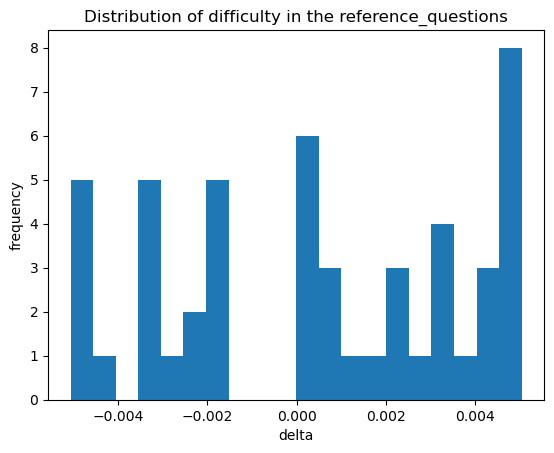

In [15]:
if ref_questions=='random':
    # Convert total_attempt_per_student and ref_question_interwal to integers
    total_attempt_per_student = int(total_attempt_per_student)
    ref_question_interwal = int(ref_question_interwal)

    mean = question_list['delta'].mean()
    std = question_list['delta'].std()

    # Generate random sample of indices from normal distribution
    n = math.ceil(total_attempt_per_student // ref_question_interwal)

    # Step 3: Generate random numbers from a normal distribution
    sample_deltas = np.random.normal(mean, std, size=len(question_list))

    # Step 4: Sort the question_list based on delta differences
    question_list['delta_diff'] = np.abs(question_list['delta'] - sample_deltas)
    question_list = question_list.sort_values('delta_diff')

    # Step 5: Select the top rows from the sorted question_list
    reference_questions = question_list.head(n)

elif ref_questions=='around_0':
    
    n = math.ceil(total_attempt_per_student // ref_question_interwal)
    
    # from the question_list select find the distance of each questions delta from 0
    question_list['delta_diff'] = np.abs(question_list['delta'] - 0)
    question_list = question_list.sort_values('delta_diff')
    
    # select the top n questions from the question_list
    reference_questions = question_list.head(n)
    

# remove the reference questions from the question_list
question_list = question_list[~question_list['item_id'].isin(reference_questions['item_id'])]

# remove delta_diff column from the question_list
question_list = question_list.drop('delta_diff', axis=1)
    
# plot the distribution of delta in the reference_questions 
plt.hist(reference_questions['delta'], bins=20)
plt.xlabel('delta')
plt.ylabel('frequency')
plt.title('Distribution of difficulty in the reference_questions')
plt.show()
    
    
    


### student list

In [16]:
if generate_own_student_list == 0:
        
    # read the learner_competency.csv and remove index column
    learner_competency = pd.read_csv('C:/Users/Ghislaine/Desktop/knowledge_traing_EloRating/data/kdd/sides_20_21/analyse_data/compare_pure_elo_logreg/elo/learner_competency.csv')

    # read the attempt_counter_student_spec.csv and remove index column
    attempt_counter_student_spec = pd.read_csv('C:/Users/Ghislaine/Desktop/knowledge_traing_EloRating/data/kdd/sides_20_21/analyse_data/compare_pure_elo_logreg/elo/attempt_counter_student_spec.csv')

    # read listOfKC and name the columns as specialty and specialty_name
    listOfKC= pd.read_csv('C:/Users/Ghislaine/Desktop/knowledge_traing_EloRating/data/kdd/sides_20_21/analyse_data/compare_pure_elo_logreg/elo/listOfKC.csv', header=None, skiprows=1,names=["specialty", "specialty_name"])

    spec_names_asList=listOfKC['specialty_name']
    spec_names_asList=list(spec_names_asList)
    # add 2 none values to the first position of the list
    spec_names_asList.insert(0, 'userID')
    # remove index column from learner_competency
    learner_competency = learner_competency.reset_index(drop=True)
    attempt_counter_student_spec=attempt_counter_student_spec.reset_index(drop=True)
    # change column names of learner_competency as spec_names_asList
    learner_competency.columns = spec_names_asList
    attempt_counter_student_spec.columns = spec_names_asList

    # limit the learner_competency to the specialty="addictology"
    learner_competency = learner_competency[['userID', this_spec]]
    attempt_counter_student_spec = attempt_counter_student_spec[['userID', this_spec]]

    # rename the col name of attempt_counter_student_spec this_spec as attempt
    attempt_counter_student_spec.rename(columns={this_spec: 'attempt'}, inplace=True)
    # rename the col name of learner_competency this_spec as ability
    learner_competency.rename(columns={this_spec: 'ability'}, inplace=True)

    # merge learner_competency and attempt_counter_student_spec based on userID
    student_list = pd.merge(learner_competency, attempt_counter_student_spec, on='userID')

    # keep only attempt> student_attemot_threshold
    student_list = student_list[student_list['attempt'] > student_attempt_threshold]

    # remove duplicates of the userID
    student_list = student_list.drop_duplicates(subset=['userID'])

    # student_list= first n=n_student rows of student_list
    student_list = student_list.head(n_student)

    # number of unique students in the student_list
    number_of_students = len(student_list['userID'].unique())
    # print the number of students
    print('number of students: ', number_of_students)

    # number of unique questions in the question_list
    number_of_questions = len(question_list['item_id'].unique())
    # print the number of questions
    print('number of questions: ', number_of_questions)

    student_list=assign_condition(student_list, number_of_students,condition_list)

c:\Users\Ghislaine\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\Ghislaine\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


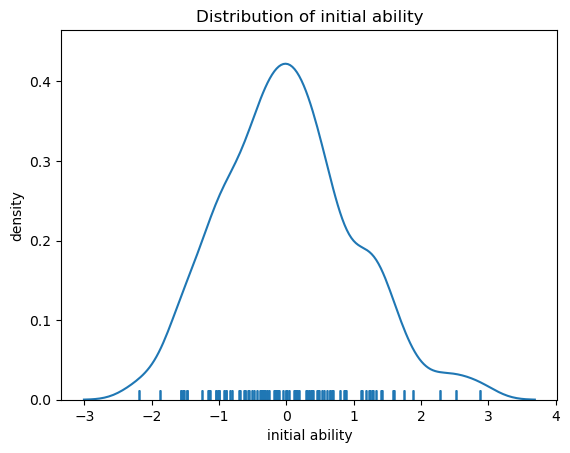

           userID  ability  attempt
condition                          
0.3           100      100      100
0.4           100      100      100
0.5           100      100      100
0.6           100      100      100
0.7           100      100      100
0.8           100      100      100
number of students:  600
number of questions:  17890


In [17]:
if generate_own_student_list == 1:
    student_list= generate_student_list(n_student,condition_list,attempt=100)
    # number of unique students in the student_list
    number_of_students = len(student_list['userID'].unique())
    # print the number of students
    print('number of students: ', number_of_students)
    # number of unique questions in the question_list
    number_of_questions = len(question_list['item_id'].unique())
    # print the number of questions
    print('number of questions: ', number_of_questions)


In [18]:
student_list

,userID,ability,attempt,condition
0,1,0.369655,100,0.3
72,73,0.111196,100,0.3
71,72,2.870825,100,0.3
70,71,0.396914,100,0.3
69,70,0.475364,100,0.3
...,...,...,...,...
527,528,1.245154,100,0.8
526,527,2.279561,100,0.8
524,525,0.336650,100,0.8
535,536,-0.006919,100,0.8


## initialize 

In [19]:
# define questionn_diffciulty as the item_id and delta columns of question_list
question_difficulty = question_list[['item_id', 'delta']]

# define learner_competency as the userID and ability columns of student_list
learner_competency = student_list[['userID', 'ability']]

unique_questions = question_list['item_id'].unique()
question_difficulty_updates_list = [{'question': qid, 'difficulty': 0} for qid in unique_questions]


if attempts_0_start == 1:
# open a datafram attempt_counter_question that for each question in question_list the attempt column is 0
    attempt_counter_question = pd.DataFrame(question_list['item_id'])
    attempt_counter_question['attempt'] = 0
else:
    # have the item_id and attempt columns together in the question_list
    attempt_counter_question = question_list[['item_id', 'attempt']]
    

if attempts_0_start == 1:
    # open a datafram attempt_counter_student_spec that for each student the attempt column is 0
    attempt_counter_student_spec = pd.DataFrame(student_list['userID'])
    attempt_counter_student_spec['attempt'] = 0
else:
    # have the userID and attempt columns together in the student_list
    attempt_counter_student_spec= student_list[['userID', 'attempt']]

unique_students = student_list['userID'].unique()
student_ability_updates_list = [{'student': uid, 'specialty': this_spec, 'ability': 0} for uid in unique_students]


## simulation function

In [20]:
def simulation_elo(student_list, total_attempt_per_student, ref_question_interwal, range_of_success_rate, hyper_params=hyper_params):
    """
    Implementation of Elo rating system for adaptive educational learning platforms.
    This function is used on the training set to learn the difficulty of items. 
    Once the difficulty of items are learneres by this function, they are used in another training function (runelo_studentability_training)to learn the competency of students. 
    
    Arguments:
    df -- train data in the form of Pandas data frame
    
    Output: data_outputs that contains elo_ExpectedScore and actual_score for each line of df
    """
    # call hyper-parameters
    a_correct = hyper_params['a_correct']
    b_correct = hyper_params['b_correct']
    a_incorrect = hyper_params['a_incorrect']
    b_incorrect = hyper_params['b_incorrect']
    
    print("Simulation is started.") 
    
    # Create arrays to store the expected score, actual score, student ID, and question ID for each row in df
    n_rows = len(student_list*total_attempt_per_student)

    #start iteration over rows in df
    for count, (index, item) in enumerate(student_list.iterrows()):
        
        # Step 0: Initialization
        uid = item['userID']
        # print in which iteration we are
        print('iteration: ', count, 'userID: ', uid)
        condition = item['condition']
        initial_ability = item['ability']
        this_question_list = copy.deepcopy(question_list)
        for n in range(total_attempt_per_student): 

            # find the student rating from the ability column of ht elearner_competency where the userID is equal to uid
            student_rating = learner_competency[learner_competency['userID'] == uid]['ability'].values[0]
            qid_order = n
            
                        # if n is the multiple of ref_question_interwal select the question from the reference_questions in the order of n/ref_question_interwal
            if n % ref_question_interwal == 0:
                order_ref_quest = int(n/ref_question_interwal)
                question_id = reference_questions['item_id'].iloc[order_ref_quest]
                question_delta = reference_questions['delta'].iloc[order_ref_quest]
                question_n_options = reference_questions['n_options'].iloc[order_ref_quest]
                question_answer_type = reference_questions['answer_type'].iloc[order_ref_quest]
                question_specialty = reference_questions['specialty'].iloc[order_ref_quest]
                
                is_ref_question = 1
                target_question_rating = np.nan
                delta_is_in_range= np.nan
                delta_distance= reference_questions['delta_diff'].iloc[order_ref_quest]
            else:
                # Step 1 : learn the targeted difficulty of the question
                target_question_rating_combinations= target_difficulty(student_rating, condition,range_of_success_rate, n_options_min=2, n_options_max=10)
                
                # Step 2 : Find Question
                # find the question with the closest difficulty to the target difficulty
                # question_id, question_delta, question_n_options, question_answer_type, question_specialty, this_question_list, delta_is_in_range = select_question(target_question_rating_combinations,this_question_list,student_rating, condition, range_of_success_rate)                
                question_id, question_delta, question_n_options, question_answer_type, question_specialty, this_question_list, delta_is_in_range, delta_distance=select_question(target_question_rating_combinations ,this_question_list)
                is_ref_question = 0
                
                # find the target_question_rating from target_question_rating_combinations in which the n_options is equal to the question_n_options and answer_type is equal to the question_answer_type
                # if the is_random==0 and if there is a row in target_question_rating_combinations in which the n_options is equal to the question_n_options and answer_type is equal to the question_answer_type
                if delta_is_in_range==1 and len(target_question_rating_combinations[(target_question_rating_combinations['n_options'] == question_n_options) & (target_question_rating_combinations['answer_type'] == question_answer_type)]) > 0:
                    target_question_rating = target_question_rating_combinations[(target_question_rating_combinations['n_options'] == question_n_options) & (target_question_rating_combinations['answer_type'] == question_answer_type)]['exact_target_question_rating'].values[0]
                else:
                    target_question_rating = np.nan

            # Step 3: calculate the expected outcome based on proficiency on all topics
            u_item_expected_result = expect_score(student_rating, question_delta, question_n_options,question_answer_type)
            #n_prev_updates =the attempt where hte userID=uid in the attempt_counter_student_spec dataframe
            n_prev_updates = attempt_counter_student_spec[attempt_counter_student_spec['userID'] == uid]['attempt'].values[0]
            
            # Step 4: simulate the real outcome by using a Bernoulli random variable 
            correct = np.random.binomial(1, u_item_expected_result)
            
            # step 5: update the student rating
            if correct == 1:
                change = uncertainty_k(n=n_prev_updates, a=a_correct, b=b_correct,update_for='student') * (correct - u_item_expected_result)
            else:
                change = uncertainty_k(n=n_prev_updates,a=a_incorrect,b=b_incorrect,update_for='student') * (correct - u_item_expected_result)
                
            # update the ability of userID=uid in the learner_competency dataframe
            learner_competency.loc[learner_competency['userID'] == uid, 'ability'] += change
            # update the attempt where hte userID=uid in the attempt_counter_student_spec dataframe
            attempt_counter_student_spec.loc[attempt_counter_student_spec['userID'] == uid, 'attempt'] += 1
            
            # Steo 6: concat the data_output that contain: uid, condition, student_rating, question_id, question_delta, question_n_options, question_answer_type, correct, is_ref_question, n_prev_updates, u_item_expected_result
            data_outputs = pd.DataFrame({'uid': uid, 'condition': condition, 'student_rating': student_rating, 'question_id': question_id, 'question_order':qid_order ,'question_delta': question_delta,'target_question_rating':target_question_rating, 'question_n_options': question_n_options, 'question_answer_type': question_answer_type, 'correct': correct, 'is_ref_question': is_ref_question, 'n_prev_updates': n_prev_updates, 'estimated_probability': u_item_expected_result, 'initial_ability':initial_ability,'question_specialty':question_specialty,'delta_is_in_range':delta_is_in_range,'delta_distance':delta_distance}, index=[0])
            # if data_output is not defined, define it as data_outputs
            if 'data_output' not in locals():
                data_output = data_outputs
            else:
                # if data_output is defined, concat the data_outputs to data_output
                data_output = pd.concat([data_output, data_outputs])
            
    print("Simulation completed")
    
    return data_output, learner_competency, attempt_counter_student_spec



In [21]:
data_output, learner_competency, attempt_counter_student_spec= simulation_elo(student_list, total_attempt_per_student, ref_question_interwal, range_of_success_rate, hyper_params=hyper_params)

Simulation is started.
iteration:  0 userID:  1.0
iteration:  1 userID:  73.0
iteration:  2 userID:  72.0
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
completely random question
com

In [22]:
# print the first 10 rows of data_output
data_output.head(10)

,uid,condition,student_rating,question_id,question_order,question_delta,target_question_rating,question_n_options,question_answer_type,correct,is_ref_question,n_prev_updates,estimated_probability,initial_ability,question_specialty,delta_is_in_range,delta_distance
0,1.0,0.3,0.369655,107044,0,0.000000,NaN,1,QUA,1,1,0,1.000000,0.369655,therapeutic_pharmacology+infectious_diseases,NaN,0.000000
0,1.0,0.3,0.369655,90182,1,1.330867,1.330712,5,QMA,0,0,1,0.299970,0.369655,infectious_diseases,1.0,0.000155
0,1.0,0.3,0.169675,34415,2,1.130594,1.130732,5,QMA,0,0,2,0.300027,0.369655,public_health+pediatrics+pneumonology+infectio...,1.0,0.000138
0,1.0,0.3,0.019661,33538,3,0.980528,0.980718,5,QMA,0,0,3,0.300037,0.369655,neurology+neurosurgery+public_health+obstetric...,1.0,0.000190
0,1.0,0.3,-0.100353,13643,4,0.860620,0.860703,5,QMA,1,0,4,0.300016,0.369655,pediatrics+infectious_diseases+anesthesiology_...,1.0,0.000084
0,1.0,0.3,0.132975,41789,5,1.094046,1.094031,5,QMA,0,0,5,0.299997,0.369655,infectious_diseases,1.0,0.000015
0,1.0,0.3,0.047261,112636,6,1.008499,1.008318,5,QMA,1,0,6,0.299965,0.369655,infectious_diseases,1.0,0.000181
0,1.0,0.3,0.222270,98995,7,1.183455,1.183327,5,QMA,0,0,7,0.299975,0.369655,pneumonology+hematology+infectious_diseases,1.0,0.000128
0,1.0,0.3,0.155609,81636,8,1.116817,1.116666,5,QMA,0,0,8,0.299971,0.369655,infectious_diseases,1.0,0.000152
0,1.0,0.3,0.095615,71997,9,1.056446,1.056671,5,QMA,0,0,9,0.300044,0.369655,infectious_diseases,1.0,0.000225


### Save the outputs

In [23]:
# open a folder named simulation_data_output
if not os.path.exists('simulation_output'):
    os.makedirs('simulation_output')
    
# save the data_output as csv to the simulation_data_output folder
data_output.to_csv('simulation_output/simulation_data_output.csv', index=False)
# save the learner_competency as csv to the simulation_data_output folder
learner_competency.to_csv('simulation_output/simulation_learner_competency.csv', index=False)
# save the attempt_counter_student_spec as csv to the simulation_data_output folder
attempt_counter_student_spec.to_csv('simulation_output/simulation_attempt_counter_student_spec.csv', index=False)
# save the attempt_counter_question as csv to the simulation_data_output folder
attempt_counter_question.to_csv('simulation_output/simulation_attempt_counter_question.csv', index=False)
# save the question_difficulty as csv to the simulation_data_output folder
question_difficulty.to_csv('simulation_output/simulation_question_difficulty.csv', index=False)
# save the reference_questions as csv to the simulation_data_output folder
reference_questions.to_csv('simulation_output/simulation_reference_questions.csv', index=False)
# save the question_list as csv to the simulation_data_output folder
question_list.to_csv('simulation_output/simulation_question_list.csv', index=False)
# save the student_list as csv to the simulation_data_output folder
student_list.to_csv('simulation_output/simulation_student_list.csv', index=False)


## ANALYSIS

### color palette

In [40]:
# Set the desired color palette
# Get the unique conditions from the data
unique_conditions = data_output['condition'].unique()

# Generate a color palette based on the number of unique conditions
color_palette = sns.color_palette("Set2", len(unique_conditions))

### call the outputs

In [56]:
# call data_output from the simulation_data_output folder
data_output = pd.read_csv('simulation_output/simulation_data_output.csv')
# call student_list from the simulation_data_output folder
student_list = pd.read_csv('simulation_output/simulation_student_list.csv')
# call question_list from the simulation_data_output folder
question_list = pd.read_csv('simulation_output/simulation_question_list.csv')
# call reference_questions from the simulation_data_output folder
reference_questions = pd.read_csv('simulation_output/simulation_reference_questions.csv')
# call question_difficulty from the simulation_data_output folder
question_difficulty = pd.read_csv('simulation_output/simulation_question_difficulty.csv')
# call attempt_counter_question from the simulation_data_output folder
attempt_counter_question = pd.read_csv('simulation_output/simulation_attempt_counter_question.csv')
# call attempt_counter_student_spec from the simulation_data_output folder
attempt_counter_student_spec = pd.read_csv('simulation_output/simulation_attempt_counter_student_spec.csv')
# call learner_competency from the simulation_data_output folder
learner_competency = pd.read_csv('simulation_output/simulation_learner_competency.csv')


# reference questions

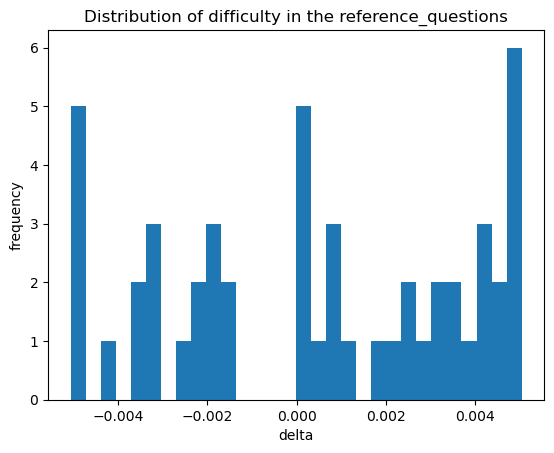

c:\Users\Ghislaine\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

c:\Users\Ghislaine\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



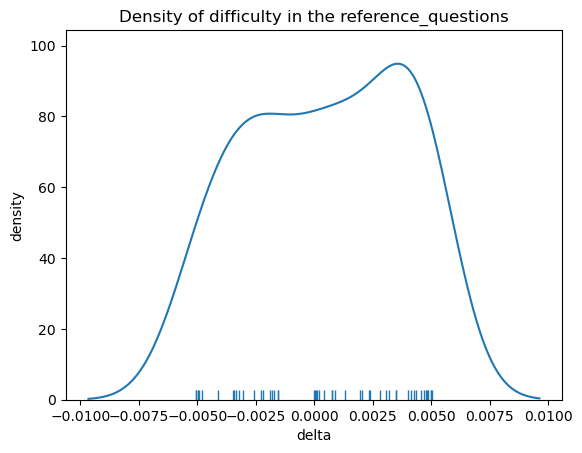

In [44]:
# plot the distribution of delta in the reference_questions 
plt.hist(reference_questions['delta'], bins=30)
plt.xlabel('delta')
plt.ylabel('frequency')
plt.title('Distribution of difficulty in the reference_questions')
plt.show()

# plot density of delta in the reference_questions
sns.distplot(reference_questions['delta'], hist=False, rug=True)
plt.xlabel('delta')
plt.ylabel('density')
plt.title('Density of difficulty in the reference_questions')
plt.show()


### data output question difficulty

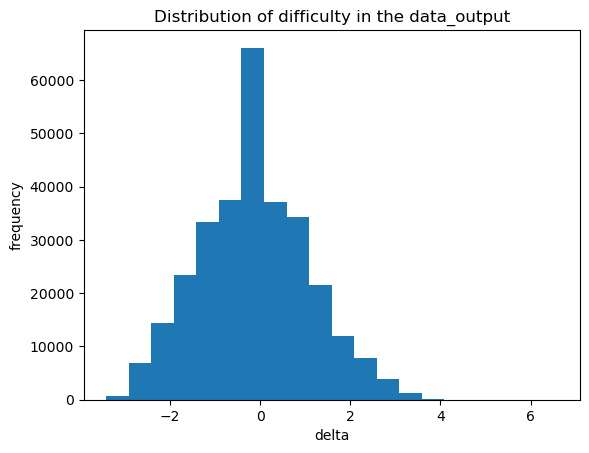

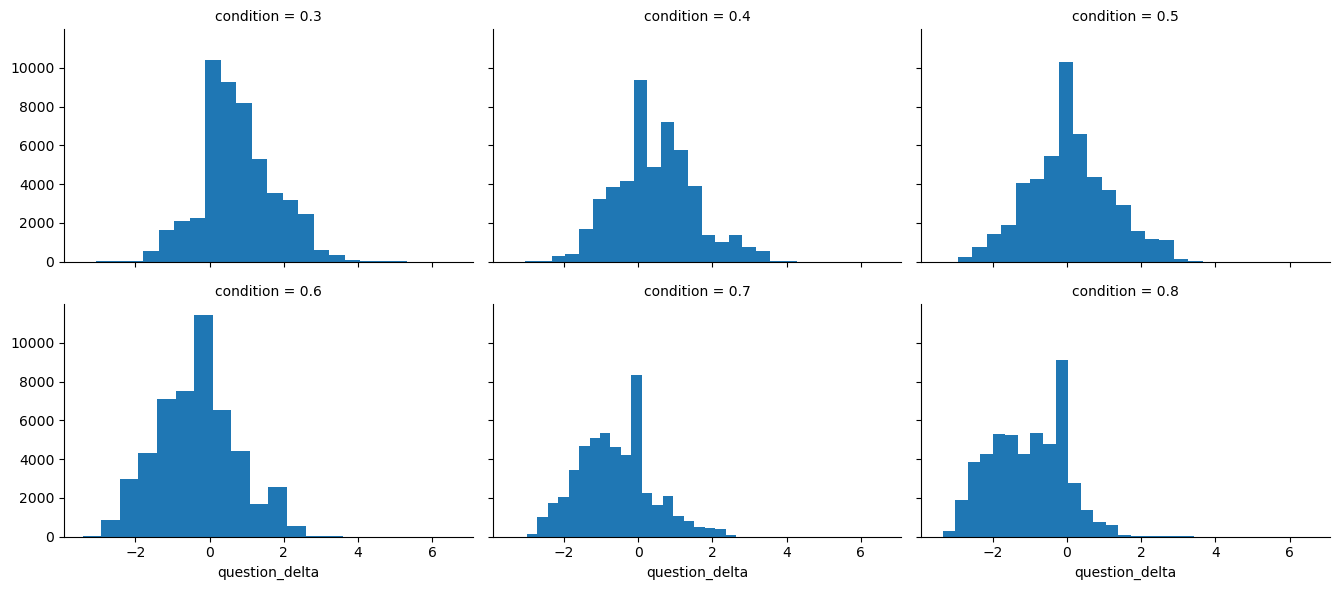

In [51]:
# plot the distribution of delta in the data_output
plt.hist(data_output['question_delta'], bins=20)
plt.xlabel('delta')
plt.ylabel('frequency')
plt.title('Distribution of difficulty in the data_output')
plt.show()

# do the same plot but facet by condition in the same line
g = sns.FacetGrid(data_output, col="condition", col_wrap=3, height=3, aspect=1.5)
g.map(plt.hist, "question_delta", bins=20)
plt.show()






### Initial abilities 

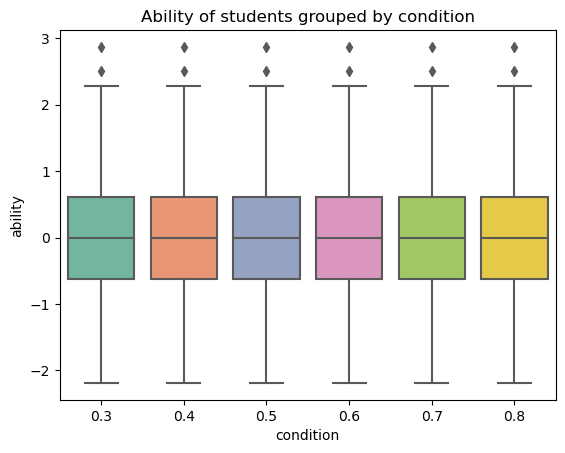

In [57]:
# in student_list, get the mean and standard deviation of the ability of the students grouped by condition but as a seperate dataframe
student_list_mean = student_list.groupby('condition')['ability'].mean().reset_index()
student_list_std = student_list.groupby('condition')['ability'].std().reset_index()



# boxplot of the ability of the students grouped by condition
sns.boxplot(x='condition', y='ability', data=student_list, palette=color_palette)
plt.title('Ability of students grouped by condition')
plt.show()



### Final abilities

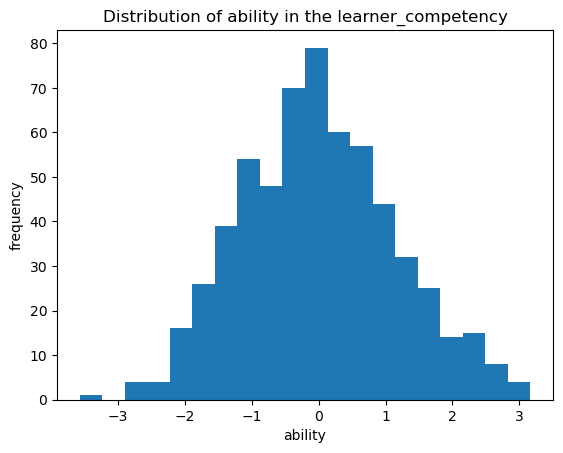

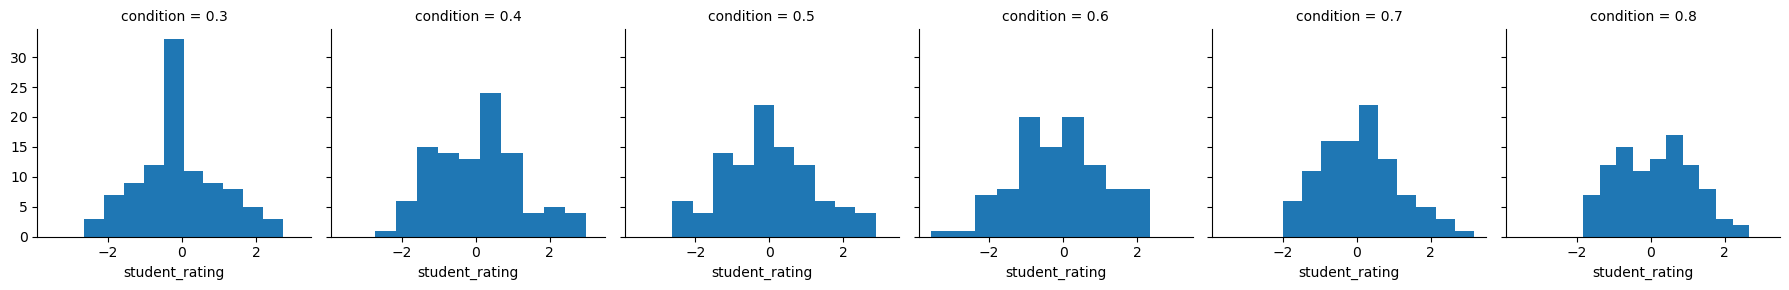

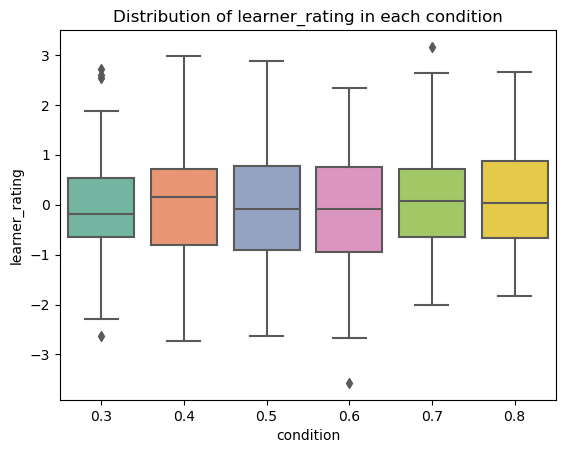

,condition,student_rating
0,0.3,-0.077400
1,0.4,0.047950
2,0.5,-0.025535
3,0.6,-0.111492
4,0.7,0.079416
5,0.8,0.109519


In [52]:
# plot the distribution of ability in the learner_competency
plt.hist(learner_competency['ability'], bins=20)
plt.xlabel('ability')
plt.ylabel('frequency')
plt.title('Distribution of ability in the learner_competency')
plt.show()

# plot the learner_rating distribution in each 6 condition in the data_output by using facetgrid
g = sns.FacetGrid(last_attempt_data_output, col='condition',palette=color_palette)
g.map(plt.hist, 'student_rating')
plt.show()


last_attempt_data_output = data_output.groupby('uid').tail(1)
# plot the learner_rating in each 6 condition
sns.boxplot(x='condition', y='student_rating', data=last_attempt_data_output,palette=color_palette)
plt.xlabel('condition')
plt.ylabel('learner_rating')
plt.title('Distribution of learner_rating in each condition')
plt.show()

# plot the same plot as above but with plotly
fig = px.box(last_attempt_data_output, x="condition", y="student_rating", color="condition", notched=True)
fig.show()


# for each student select the last attempt rows from data_output
last_attempt_data_output = data_output.groupby('uid').tail(1)
# get the mean of student_rating for each condition as df
mean_student_rating = last_attempt_data_output.groupby('condition')['student_rating'].mean().reset_index()
mean_student_rating




### Student Rating Evolutions

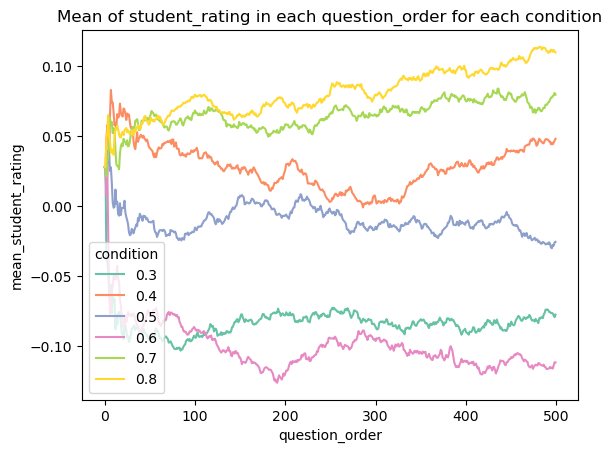

In [33]:
# plot the mean of student_rating in each question_order for each condition
# get the mean of student_rating for each question_order for each condition as df
mean_student_rating_question_order = data_output.groupby(['condition','question_order'])['student_rating'].mean().reset_index()
# plot the mean_student_rating_question_order
sns.lineplot(x='question_order', y='student_rating', hue='condition', data=mean_student_rating_question_order,palette=color_palette)
plt.xlabel('question_order')
plt.ylabel('mean_student_rating')
plt.title('Mean of student_rating in each question_order for each condition')
plt.show()



### Initial and last ability comparison

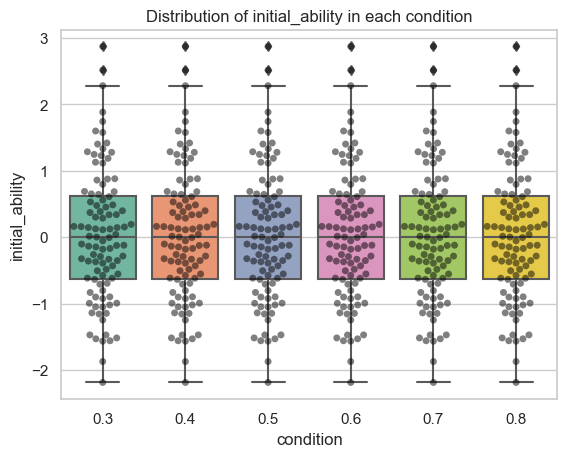

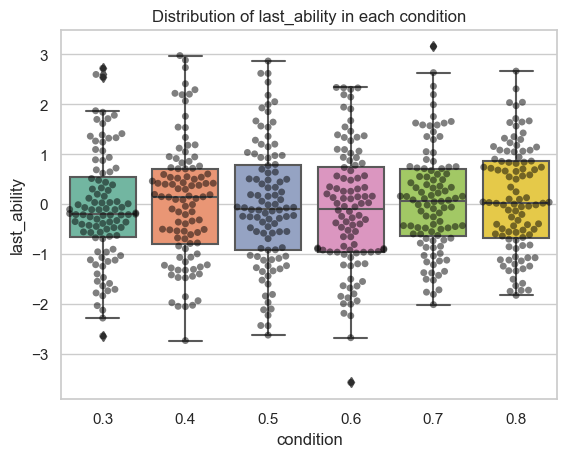

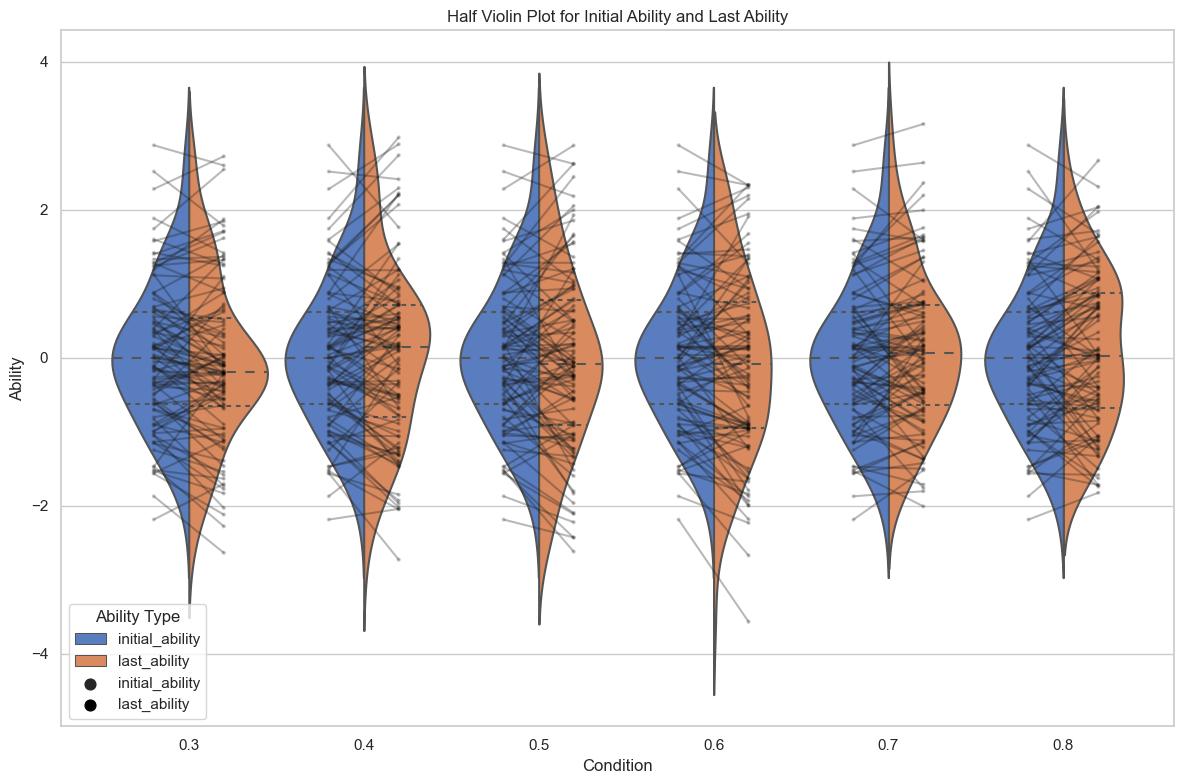

In [112]:
# from the data_output select the first row for each uid but in seperate dataframe
first_attempt_data_output = data_output.groupby('uid').head(1)
# get the mean of initial_ability for each condition as df
mean_initial_ability = first_attempt_data_output.groupby('condition')['initial_ability'].mean().reset_index()
mean_initial_ability
# plot the initial_ability in each condition by boxplot
sns.boxplot(x='condition', y='initial_ability', data=first_attempt_data_output, palette=color_palette)
sns.swarmplot(x='condition', y='initial_ability', data=first_attempt_data_output, color='black', alpha=0.5)
plt.xlabel('condition')
plt.ylabel('initial_ability')
plt.title('Distribution of initial_ability in each condition')
plt.show()


# for each student select the last attempt rows from data_output
last_attempt_data_output = data_output.groupby('uid').tail(1)
# get the mean of student_rating for each condition as df
mean_last_ability = last_attempt_data_output.groupby('condition')['student_rating'].mean().reset_index()

# plot the last ability in each condition by boxplot by showing individual points
sns.boxplot(x='condition', y='student_rating', data=last_attempt_data_output, palette=color_palette)
sns.swarmplot(x='condition', y='student_rating', data=last_attempt_data_output, color='black', alpha=0.5)
plt.xlabel('condition')
plt.ylabel('last_ability')
plt.title('Distribution of last_ability in each condition')
plt.show()

# have onyl the uid, condition, and student_rating columns from the last_attempt_data_output
last_attempt_data_output = last_attempt_data_output[['uid', 'condition', 'student_rating']]
# rename the student_rating column as last_ability
last_attempt_data_output.rename(columns={'student_rating': 'last_ability'}, inplace=True)
# have onyl the uid, condition, and initial_ability columns from the first_attempt_data_output
first_attempt_data_output = first_attempt_data_output[['uid', 'condition', 'initial_ability']]
# rename the initial_ability column as initial_ability
first_attempt_data_output.rename(columns={'initial_ability': 'initial_ability'}, inplace=True)
# merge the last_attempt_data_output and first_attempt_data_output based on uid and condition
first_last_attempt_data_output = pd.merge(first_attempt_data_output, last_attempt_data_output, on=['uid', 'condition'])


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Step 2: Prepare the data by melting it into a long format
melted_data = pd.melt(first_last_attempt_data_output, id_vars=['uid', 'condition'],
                      value_vars=['initial_ability', 'last_ability'],
                      var_name='ability_type', value_name='ability')

# Step 3: Plot the violin plots with connected lines and individual points
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))

# Increase the distance between the violins by setting the width parameter
sns.violinplot(data=melted_data, x='condition', y='ability', hue='ability_type',
               split=True, width=0.9, inner='quart', palette='muted')

# Add individual points inside the violins
sns.stripplot(data=melted_data, x='condition', y='ability', hue='ability_type',
             dodge=True, jitter=False, color='black', size=3, alpha=0.2)

# Connect initial and last abilities with lines for each uid within each condition
for i, condition in enumerate(first_last_attempt_data_output['condition'].unique()):
    for uid in first_last_attempt_data_output.loc[first_last_attempt_data_output['condition'] == condition, 'uid'].unique():
        initial_ability = first_last_attempt_data_output.loc[(first_last_attempt_data_output['uid'] == uid) & (first_last_attempt_data_output['condition'] == condition), 'initial_ability'].iloc[0]
        last_ability = first_last_attempt_data_output.loc[(first_last_attempt_data_output['uid'] == uid) & (first_last_attempt_data_output['condition'] == condition), 'last_ability'].iloc[0]
        plt.plot([i - 0.2, i + 0.2], [initial_ability, last_ability], 'k-', alpha=0.3)

plt.title("Half Violin Plot for Initial Ability and Last Ability")
plt.xlabel("Condition")
plt.ylabel("Ability")
plt.legend(title="Ability Type", loc="best")
plt.tight_layout()
plt.show()






#### the percentage of is_random in each condition

In [113]:
# open a new column in data_output that named 'block_no' and group the question_order for each uid into 10 question blocks from one is_reference_question to the next is_reference_question
data_output['block_no'] = data_output.groupby('uid')['question_order'].apply(lambda x: (x-1)//10+1)


#### the percentage of question selection quality in each condition

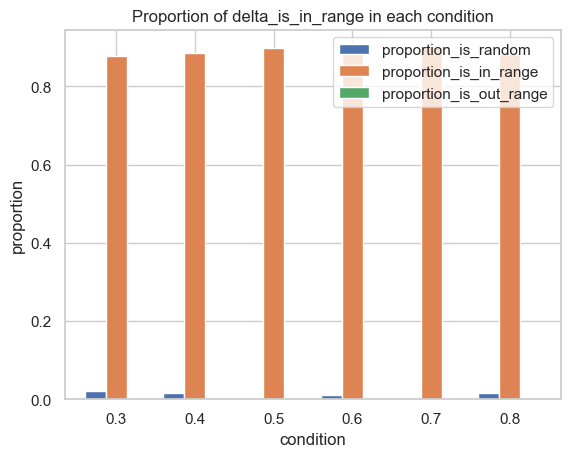

In [114]:
# for each condition calculate the proportion of delta_is_in_range=999 in the data_output
proportion_is_random= data_output.groupby('condition')['delta_is_in_range'].apply(lambda x: (x==999).mean()).reset_index()
# rename the column name of proportion_is_random as condition and proportion_is_random
proportion_is_random.rename(columns={'delta_is_in_range': 'proportion_is_random'}, inplace=True)
# for each condition calculate the proportion of delta_is_in_range=1 in the data_output
proportion_is_in_range= data_output.groupby('condition')['delta_is_in_range'].apply(lambda x: (x==1).mean()).reset_index()
# rename the column name of proportion_is_in_range as condition and proportion_is_in_range
proportion_is_in_range.rename(columns={'delta_is_in_range': 'proportion_is_in_range'}, inplace=True)
# for each condition calculate the proportion of delta_is_in_range=0 in the data_output
proportion_is_out_range= data_output.groupby('condition')['delta_is_in_range'].apply(lambda x: (x==0).mean()).reset_index()
# rename the column name of proportion_is_out_range as condition and proportion_is_out_range
proportion_is_out_range.rename(columns={'delta_is_in_range': 'proportion_is_out_range'}, inplace=True)


# merge proportion_is_random, proportion_is_in_range and proportion_is_out_range based on condition
all_proportions= pd.merge(proportion_is_random, proportion_is_in_range, on='condition')
all_proportions = pd.merge(all_proportions, proportion_is_out_range, on='condition')

# plot the proportion_is_random, proportion_is_in_range and proportion_is_out_range in each condition by putting some space between each bar for proportion_is_random, proportion_is_in_range and proportion_is_out_range
all_proportions.plot.bar(x='condition', y=['proportion_is_random', 'proportion_is_in_range', 'proportion_is_out_range'], rot=0, width=0.8)
plt.xlabel('condition')
plt.ylabel('proportion')
plt.title('Proportion of delta_is_in_range in each condition')
plt.show()





### Track the question selection

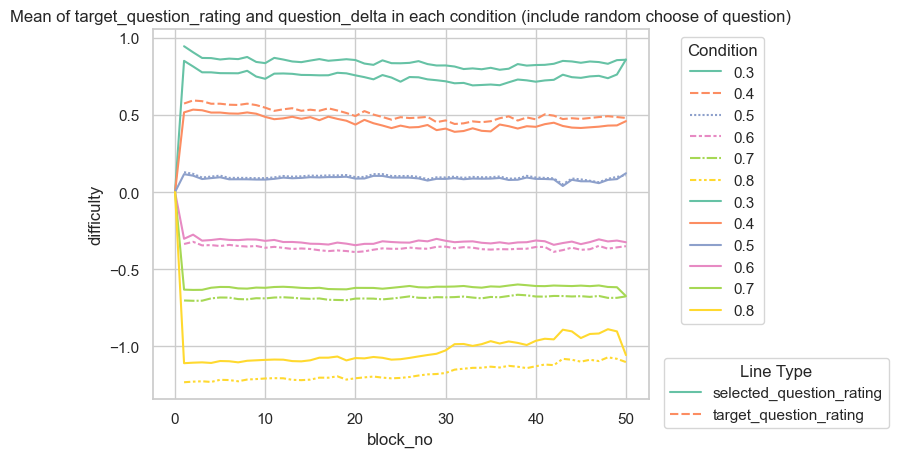

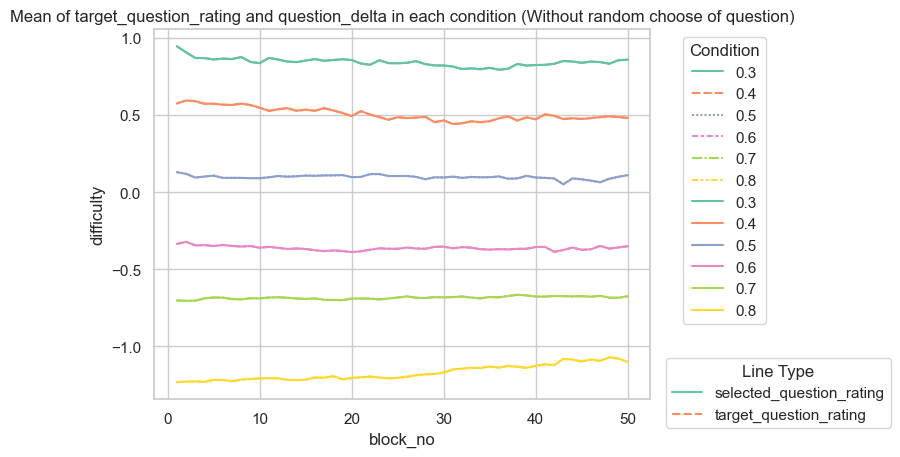

In [117]:
# for each condition and for each question_order calculate the mean and std of target_question rating and question_delta  in the data_output but use only the wuestions that are not reference questions
#mean_target_question_difficulty = data_output[data_output['is_ref_question']==0].groupby(['condition','block_no'])['target_question_rating'].mean().reset_index()
#mean_selected_question_difficulty = data_output[data_output['is_ref_question']==0].groupby(['condition','block_no'])['question_delta'].mean().reset_index()

mean_target_question_difficulty = data_output.groupby(['condition','block_no'])['target_question_rating'].mean().reset_index()
std_target_question_difficulty = data_output.groupby(['condition','block_no'])['target_question_rating'].std().reset_index()
mean_selected_question_difficulty = data_output.groupby(['condition','block_no'])['question_delta'].mean().reset_index()
std_selected_question_difficulty = data_output.groupby(['condition','block_no'])['question_delta'].std().reset_index()


# plot the mean_target_question_difficulty and mean_selected_question_difficulty in each condition and for each question_order together in the same plot, by using dashed and solid line and with the confidence interval
# make the condition colors same as the previous plot
sns.lineplot(x='block_no', y='target_question_rating', hue='condition', data=mean_target_question_difficulty, style='condition', dashes=True,ci=95,palette=color_palette)
sns.lineplot(x='block_no', y='question_delta', hue='condition', data=mean_selected_question_difficulty, style='condition', dashes=False ,ci=95,palette=color_palette)
plt.xlabel('block_no')
plt.ylabel('difficulty')
plt.title('Mean of target_question_rating and question_delta in each condition (include random choose of question)')
# Get the current axes
ax = plt.gca()
# Create the legend for condition colors and solid lines
legend1 = ax.legend(title='Condition', loc='upper left', bbox_to_anchor=(1.05, 1))
# Create the legend for dashed and solid lines
line_labels = ['selected_question_rating','target_question_rating' ]
handles, _ = ax.get_legend_handles_labels()
legend2 = ax.legend(handles[:2], line_labels, title='Line Type', loc='lower right', bbox_to_anchor=(1.5, -0.1))
# Add the first legend back to the plot
ax.add_artist(legend1)
plt.show()




# without random choose of question
# from mean_target_question_difficulty select the rows in which delta_is_in_range=1 or 0 which meand its not 999 or nan
mean_target_question_difficulty=data_output[(data_output['delta_is_in_range']==1) | (data_output['delta_is_in_range']==0)].groupby(['condition','block_no'])['target_question_rating'].mean().reset_index()
std_target_question_difficulty=data_output[(data_output['delta_is_in_range']==1) | (data_output['delta_is_in_range']==0)].groupby(['condition','block_no'])['target_question_rating'].std().reset_index()
mean_selected_question_difficulty=data_output[(data_output['delta_is_in_range']==1) | (data_output['delta_is_in_range']==0)].groupby(['condition','block_no'])['question_delta'].mean().reset_index()
std_selected_question_difficulty=data_output[(data_output['delta_is_in_range']==1) | (data_output['delta_is_in_range']==0)].groupby(['condition','block_no'])['question_delta'].std().reset_index()


# mean_target_question_difficulty = data_output[data_output['delta_is_in_range']==1].groupby(['condition','block_no'])['target_question_rating'].mean().reset_index()
# std_target_question_difficulty = data_output[data_output['delta_is_in_range']==1].groupby(['condition','block_no'])['target_question_rating'].std().reset_index()
# mean_selected_question_difficulty = data_output[data_output['delta_is_in_range']==1].groupby(['condition','block_no'])['question_delta'].mean().reset_index()
# std_selected_question_difficulty = data_output[data_output['delta_is_in_range']==1].groupby(['condition','block_no'])['question_delta'].std().reset_index()
# plot the mean_target_question_difficulty and mean_selected_question_difficulty in each condition and for each question_order together in the same plot, by using dashed and solid line and with the confidence interval
# make the condition colors same as the previous plot
sns.lineplot(x='block_no', y='target_question_rating', hue='condition', data=mean_target_question_difficulty, style='condition', dashes=True,ci=95,palette=color_palette)
sns.lineplot(x='block_no', y='question_delta', hue='condition', data=mean_selected_question_difficulty, style='condition', dashes=False ,ci=95,palette=color_palette)
plt.xlabel('block_no')
plt.ylabel('difficulty')
plt.title('Mean of target_question_rating and question_delta in each condition (Without random choose of question)')
# Get the current axes
ax = plt.gca()
# Create the legend for condition colors and solid lines
legend1 = ax.legend(title='Condition', loc='upper left', bbox_to_anchor=(1.05, 1))
# Create the legend for dashed and solid lines
line_labels = ['selected_question_rating','target_question_rating' ]
handles, _ = ax.get_legend_handles_labels()
legend2 = ax.legend(handles[:2], line_labels, title='Line Type', loc='lower right', bbox_to_anchor=(1.5, -0.1))
# Add the first legend back to the plot
ax.add_artist(legend1)
plt.show()

### analysis: effect of conditions

In [122]:
first_last_attempt_data_output
# print unique conditions
unique_conditions = first_last_attempt_data_output['condition'].unique()
# print unique conditions
unique_conditions

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

final ability ~ initial ability * condition

In [136]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
df = pd.DataFrame(first_last_attempt_data_output)

# Convert conditions to integers (multiply by 10 and round to nearest integer)
df['condition_int'] = (df['condition'] * 10).round(0).astype(int)

# Standardize the initial_ability variable (subtract the mean and divide by the standard deviation)
df['initial_ability_standardized'] = (df['initial_ability'] - df['initial_ability'].mean()) / df['initial_ability'].std()

# Fit the linear mixed model
model = smf.mixedlm("last_ability ~ condition_int * initial_ability_standardized", df, groups=df['uid'])
result = model.fit()

print(result.summary())

                        Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          last_ability
No. Observations:          600              Method:                      REML        
No. Groups:                600              Scale:                       0.1992      
Min. group size:           1                Log-Likelihood:              -585.2916   
Max. group size:           1                Converged:                   Yes         
Mean group size:           1.0                                                       
-------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                  -0.144    0.087 -1.662 0.096 -0.315  0.026
condition_int                               0.027    0.015  1.786 0.074 -0.003

c:\Users\Ghislaine\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



### interaction plot

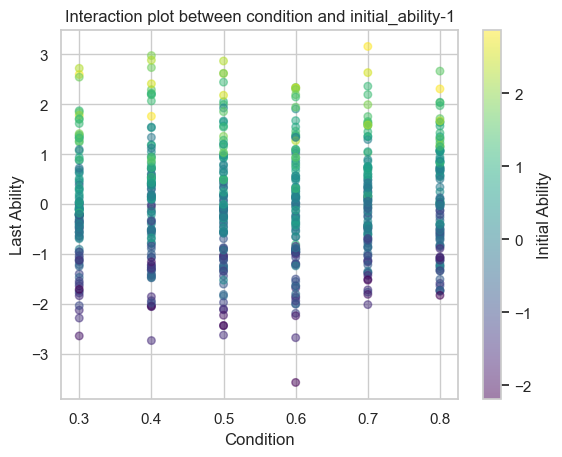

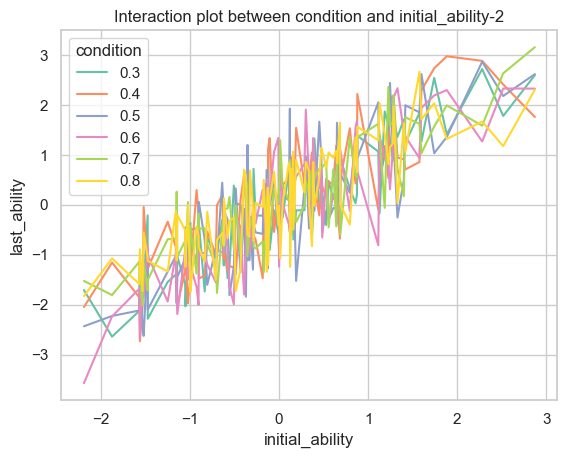

In [139]:
df = pd.DataFrame(first_last_attempt_data_output)
# Create a list of conditions you want to analyze
conditions_to_analyze = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Create a scatter plot for each condition while controlling initial_ability with different colors and smaller, more transparent points
for condition in conditions_to_analyze:
    condition_df = df[df['condition'] == condition]
    plt.scatter(condition_df['condition'], condition_df['last_ability'], c=condition_df['initial_ability'], cmap='viridis', label=f'Condition {condition}', s=30, alpha=0.5)

# Add labels, colorbar, and title
plt.xlabel('Condition')
plt.ylabel('Last Ability')
plt.colorbar(label='Initial Ability')
plt.title('Interaction plot between condition and initial_ability-1')
plt.show()



# plot an interaction plot between condition and initial_ability
sns.lineplot(x='initial_ability', y='last_ability', hue='condition', data=df, palette=color_palette)
plt.xlabel('initial_ability')
plt.ylabel('last_ability')
plt.title('Interaction plot between condition and initial_ability-2')
plt.show()


### condition as continuous variable


In [119]:
first_last_attempt_data_output

# linear mixed model for the last_ability as dependent variable and condition and initial_ability as independent variables and their interaction
import statsmodels.api as sm
import statsmodels.formula.api as smf
# fit the model
model = smf.mixedlm("last_ability ~ condition * initial_ability", first_last_attempt_data_output, groups=first_last_attempt_data_output["uid"])
model_fit = model.fit()
# print the summary of the model
print(model_fit.summary())


# test the effect of condition on last_ability by adjusting the initial_ability
# fit the model



c:\Users\Ghislaine\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    last_ability
No. Observations:     600        Method:                REML        
No. Groups:           600        Scale:                 0.1992      
Min. group size:      1          Log-Likelihood:        -580.6477   
Max. group size:      1          Converged:             Yes         
Mean group size:      1.0                                           
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 -0.175    0.071 -2.470 0.014 -0.314 -0.036
condition                  0.276    0.117  2.357 0.018  0.047  0.505
initial_ability            1.106    0.055 19.924 0.000  0.997  1.214
condition:initial_ability -0.235    0.097 -2.430 0.015 -0.424 -0.045
Group Var                  0.199                  

In [ ]:
last_attempt_data_output

In [ ]:
# from data_output select the row with the biggest question_order for each uid
last_attempt_data_output = data_output.groupby('uid').tail(1)
# name the column of last_attempt_data_output as last_ability
last_attempt_data_output.rename(columns={'student_rating': 'last_ability'}, inplace=True)

# plot the initial_ability and last_ability as seperate violin plots in each condition and put them together in the same plot with different colors for each condition
sns.violinplot(x='condition', y='initial_ability', data=last_attempt_data_output, color='blue', label='initial_ability')
sns.violinplot(x='condition', y='last_ability', data=last_attempt_data_output, color='red', label='last_ability')
# plot each student's initial_ability and last_ability as a point in the same plot
sns.swarmplot(x='condition', y='initial_ability', data=last_attempt_data_output, color='blue', alpha=0.5)
sns.swarmplot(x='condition', y='last_ability', data=last_attempt_data_output, color='red', alpha=0.5)
# plot connecting lines between each student's initial_ability and last_ability
sns.lineplot(x='condition', y='initial_ability', data=last_attempt_data_output, color='blue', alpha=0.5)
sns.lineplot(x='condition', y='last_ability', data=last_attempt_data_output, color='red', alpha=0.5)
plt.xlabel('condition')
plt.ylabel('ability')
plt.title('Initial_ability and last_ability in each condition')
plt.legend()
plt.show()



In [ ]:
# Plot the initial_ability and last_ability as separate violin plots in each condition
sns.violinplot(x='condition', y='initial_ability', data=last_attempt_data_output, color='blue', label='initial_ability', inner='quart')
sns.violinplot(x='condition', y='last_ability', data=last_attempt_data_output, color='red', label='last_ability', inner='quart', offset=0.4)

# Plot each student's initial_ability and last_ability as points in the same plot with separation
sns.swarmplot(x='condition', y='initial_ability', data=last_attempt_data_output, color='blue', alpha=0.5, dodge=True)
sns.swarmplot(x='condition', y='last_ability', data=last_attempt_data_output, color='red', alpha=0.5, dodge=True)

# Plot connecting lines between each student's initial_ability and last_ability
sns.lineplot(x='condition', y='initial_ability', data=last_attempt_data_output, color='blue', alpha=0.5)
sns.lineplot(x='condition', y='last_ability', data=last_attempt_data_output, color='red', alpha=0.5)

plt.xlabel('condition')
plt.ylabel('ability')
plt.title('Initial_ability and last_ability in each condition')
plt.legend()
plt.show()

In [ ]:
# Plot the initial_ability as violin plot with blue color
sns.violinplot(x='condition', y='initial_ability', data=last_attempt_data_output, color='blue', label='initial_ability', inner='quart')

# Plot the last_ability as point plot with red color
sns.pointplot(x='condition', y='last_ability', data=last_attempt_data_output, color='red', label='last_ability', ci=None)

plt.xlabel('condition')
plt.ylabel('ability')
plt.title('Initial_ability and last_ability in each condition')
plt.legend()
plt.show()

In [ ]:
last_attempt_data_output


In [ ]:

# name the column of last_attempt_data_output as last_ability
last_attempt_data_output.rename(columns={'student_rating': 'last_ability'}, inplace=True)



In [ ]:
data_output

In [ ]:
first_attempt_data_output

#### Learning curve

In [140]:
# from the data_output seelct the rows where is_ref_question=1
ref_question_data_output = data_output[data_output['is_ref_question'] == 1]
ref_question_data_output

,uid,condition,student_rating,question_id,question_order,question_delta,target_question_rating,question_n_options,question_answer_type,correct,is_ref_question,n_prev_updates,estimated_probability,initial_ability,question_specialty,delta_is_in_range,delta_distance,block_no
0,1.0,0.3,0.369655,107044,0,0.000000,NaN,1,QUA,1,1,0,1.000000,0.369655,therapeutic_pharmacology+infectious_diseases,NaN,0.000000,0
10,1.0,0.3,0.041061,84819,10,0.000031,NaN,5,QMA,0,1,10,0.526054,0.369655,gerontology+hepatogastroenterology+infectious_...,NaN,0.000031,1
20,1.0,0.3,0.118867,111379,20,0.000057,NaN,5,QUA,0,1,20,0.623734,0.369655,infectious_diseases,NaN,0.000057,2
30,1.0,0.3,-0.068274,84815,30,0.000102,NaN,5,QMA,0,1,30,0.499593,0.369655,gerontology+hepatogastroenterology+infectious_...,NaN,0.000102,3
40,1.0,0.3,0.024122,123450,40,0.000224,NaN,5,QMA,0,1,40,0.521911,0.369655,public_health+infectious_diseases,NaN,0.000224,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299950,600.0,0.8,0.070435,109379,450,0.004987,NaN,5,QMA,1,1,450,0.531957,0.000321,infectious_diseases,NaN,0.004987,45
299960,600.0,0.8,-0.011542,71459,460,0.005013,NaN,5,QMA,0,1,460,0.512124,0.000321,infectious_diseases+anesthesiology_resuscitati...,NaN,0.005013,46
299970,600.0,0.8,-0.002877,40194,470,-0.005035,NaN,5,QMA,0,1,470,0.516651,0.000321,infectious_diseases,NaN,0.005035,47
299980,600.0,0.8,0.005626,68963,480,0.005040,NaN,5,QMA,1,1,480,0.516271,0.000321,therapeutic_pharmacology+toxicology+infectious...,NaN,0.005040,48


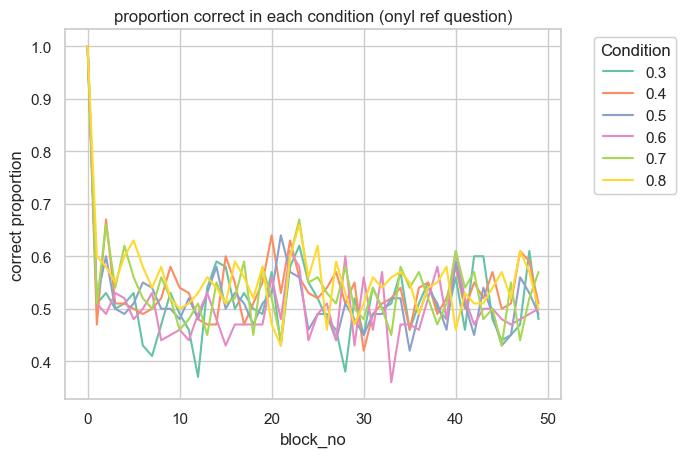

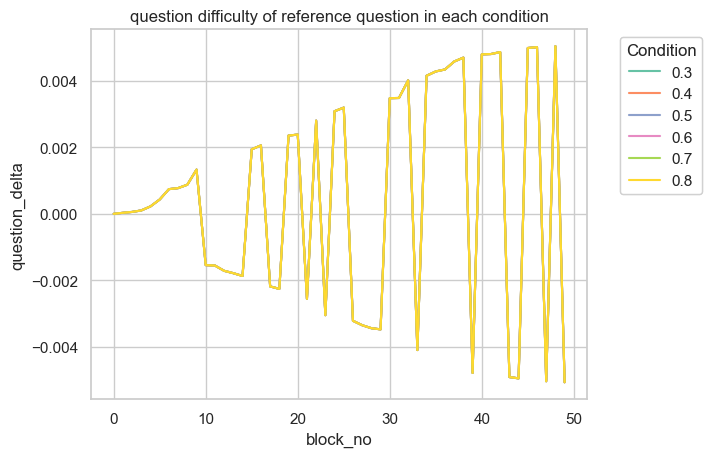

In [141]:
# get the mean of estimated_probability for each uid grouped by condition and block_no
mean_estimated_ability = ref_question_data_output.groupby(['condition','block_no'])['estimated_probability'].mean().reset_index()
mean_estimated_ability

# get the mean of question_delta for each uid grouped by condition and block_no
mean_question_delta = ref_question_data_output.groupby(['condition','block_no'])['question_delta'].mean().reset_index()

# get the porportion correct for each uid grouped by condition and block_no
proportion_correct = ref_question_data_output.groupby(['condition','block_no'])['correct'].mean().reset_index()
proportion_correct

# merge the mean_estimated_ability and mean_question_delta and proportion_correct into one dataframe
mean_estimated_ability = mean_estimated_ability.merge(mean_question_delta, on=['condition','block_no'])
mean_estimated_ability = mean_estimated_ability.merge(proportion_correct, on=['condition','block_no'])
mean_estimated_ability

# plot the correct proportion each block_no in each condition
sns.lineplot(x='block_no', y='correct', hue='condition', data=mean_estimated_ability, style='condition', dashes=False,ci=95,palette=color_palette)
plt.xlabel('block_no')
plt.ylabel('correct proportion')
plt.title('proportion correct in each condition (onyl ref question)')
# Get the current axes
ax = plt.gca()
# Create the legend for condition colors and solid lines
legend1 = ax.legend(title='Condition', loc='upper left', bbox_to_anchor=(1.05, 1))
# Add the first legend back to the plot
ax.add_artist(legend1)
plt.show()

# plot the question_delta each block_no in each condition
sns.lineplot(x='block_no', y='question_delta', hue='condition', data=mean_estimated_ability, style='condition', dashes=False,ci=95,palette=color_palette)
plt.xlabel('block_no')
plt.ylabel('question_delta')
plt.title('question difficulty of reference question in each condition')
# Get the current axes
ax = plt.gca()
# Create the legend for condition colors and solid lines
legend1 = ax.legend(title='Condition', loc='upper left', bbox_to_anchor=(1.05, 1))
# Add the first legend back to the plot
ax.add_artist(legend1)
plt.show()



## Learning curve

In [ ]:
ref_question_data_output

# create a new column called 'error rate' which is 1-

In [ ]:
proportion_correct

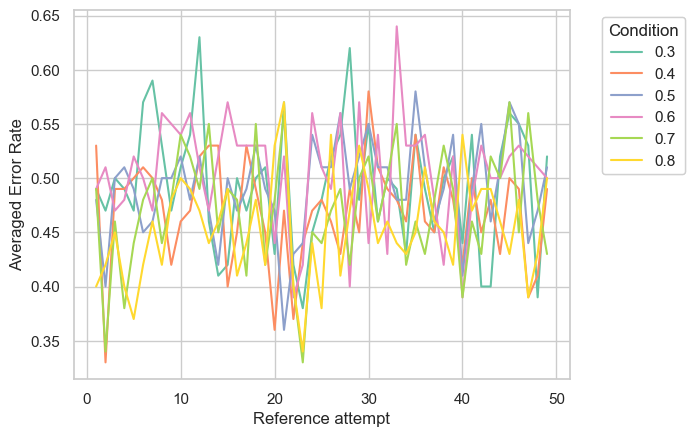

In [143]:
ref_question_data_output = data_output[data_output['is_ref_question'] == 1]
ref_question_data_output

# get the porportion correct for each uid grouped by condition and block_no but keep the n_previous_attempts
proportion_correct = ref_question_data_output.groupby(['condition','block_no','n_prev_updates'])['correct'].mean().reset_index()
#proportion_correct = ref_question_data_output.groupby(['condition','block_no'])['correct'].mean().reset_index()

# create a new column called 'error rate' which is 1-proportion_correct
proportion_correct['error_rate'] = 1 - proportion_correct['correct']
proportion_correct

# remove the first block_no for each uid
proportion_correct = proportion_correct[proportion_correct['block_no'] != 0]


# plot the error rate each block_no in each condition
sns.lineplot(x='block_no', y='error_rate', hue='condition', data=proportion_correct, style='condition', dashes=False,ci=95,palette=color_palette)
plt.xlabel('Reference attempt')
plt.ylabel('Averaged Error Rate')
#plt.title('Learning Curve')
# Get the current axes
ax = plt.gca()
# Create the legend for condition colors and solid lines
legend1 = ax.legend(title='Condition', loc='upper left', bbox_to_anchor=(1.05, 1))
# Add the first legend back to the plot
ax.add_artist(legend1)
plt.show()






# get the mean of correct for each condition



In [ ]:
proportion_correct = ref_question_data_output.groupby(['condition'])['correct'].mean().reset_index()
proportion_correct


# plot the proportion correct in each condition
sns.barplot(x='condition', y='correct', data=proportion_correct, palette=color_palette)
plt.xlabel('condition')
plt.ylabel('proportion correct')
plt.title('proportion correct in each condition (only ref question)')
plt.show()




In [ ]:
data_output


In [ ]:
mean_expected_score = data_output[data_output['is_random']==0].groupby(['condition'])['estimated_probability'].mean().reset_index()
# rename the estimated_probability column to mean_expected_score
mean_expected_score = mean_expected_score.rename(columns={'estimated_probability':'mean_expected_score'})
mean_expected_score


# find the is_random==0 in data_output and name it as data_output_without_random
data_output_without_random = data_output[data_output['is_random']==0]

# plot the estimated_ability as box plot in each condition
sns.boxplot(x='condition', y='estimated_probability', data=data_output_without_random, palette=color_palette)
plt.xlabel('condition')
plt.ylabel('estimated_ability')
plt.title('expected score in each condition (Without random choose of question)')
plt.show()